## **Fraud Detection**

The notebook provides technical and theoretical insights and demonstrates how to implement fraud detection models. It is a succint version used for demo purposes.

**Imports**

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN
import seaborn as sns
from itertools import product
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora
import pyLDAvis.gensim

**Pandas Configuration Options**

In [3]:
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 300)
pd.set_option('display.expand_frame_repr', True)

**Data File Objects**

In [4]:
data = Path.cwd() / 'data'

fd1 = data / '1_FD_data_prepping'
cc1_file = fd1 / 'creditcard_sampledata.csv'
cc3_file = fd1 / 'creditcard_sampledata_3.csv'

fd2 = data / '2_FD_supervised'
cc2_file = fd2 / 'creditcard_sampledata_2.csv'

fd3 = data / '3_FD_unsupervised'
banksim_file = fd3 / 'banksim.csv'
banksim_adj_file = fd3 / 'banksim_adj.csv'
db_full_file = fd3 / 'db_full.pickle'
labels_file = fd3 / 'labels.pickle'
labels_full_file = fd3 / 'labels_full.pickle'
x_scaled_file = fd3 / 'x_scaled.pickle'
x_scaled_full_file = fd3 / 'x_scaled_full.pickle'

fd4 = data / '4_FD_NLP'
enron_emails_clean_file = fd4 / 'enron_emails_clean.csv'
cleantext_file = fd4 / 'cleantext.pickle'
corpus_file = fd4 / 'corpus.pickle'
dict_file = fd4 / 'dict.pickle'
ldamodel_file = fd4 / 'ldamodel.pickle'

# FD1 Prepping the Data and Imbalanced Datasets


### Checking the fraud to non-fraud ratio

In part 1, we will work on `creditcard_sampledata.csv`, a dataset containing credit card transactions data. 

Fraud occurrences are unfortunately an **extreme minority** in these transactions.

Machine Learning algorithms usually work best when the different classes contained in the dataset are more or less equally present. If there are few cases of fraud, then there's little data to learn how to identify them. This is known as **class imbalance**, and it's one of the main challenges of fraud detection.


In [5]:
df = pd.read_csv(cc3_file)

#### Explore the features available in your dataframe

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5050 non-null   int64  
 1   V1          5050 non-null   float64
 2   V2          5050 non-null   float64
 3   V3          5050 non-null   float64
 4   V4          5050 non-null   float64
 5   V5          5050 non-null   float64
 6   V6          5050 non-null   float64
 7   V7          5050 non-null   float64
 8   V8          5050 non-null   float64
 9   V9          5050 non-null   float64
 10  V10         5050 non-null   float64
 11  V11         5050 non-null   float64
 12  V12         5050 non-null   float64
 13  V13         5050 non-null   float64
 14  V14         5050 non-null   float64
 15  V15         5050 non-null   float64
 16  V16         5050 non-null   float64
 17  V17         5050 non-null   float64
 18  V18         5050 non-null   float64
 19  V19         5050 non-null  

Above is the data set we are working with. Column indexes 1-28 represent credit card features represented in representation form. 

In [7]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,258647,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,1.618952,-0.654046,-1.442665,-1.546538,-0.230008,1.785539,1.419793,0.071666,0.233031,0.275911,0.414524,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0
1,69263,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,1.521570,0.499202,-0.127849,-0.237253,-0.752351,0.667190,0.724785,-1.736615,0.702088,0.638186,0.116898,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0
2,96552,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,-0.782780,0.005242,-1.273288,-0.269260,0.091287,-0.347973,0.495328,-0.925949,0.099138,-0.083859,-0.189315,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0
3,281898,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,0.137341,-0.156740,-0.429388,-0.752392,0.155272,0.215068,0.352222,-0.376168,-0.398920,0.043715,-0.335825,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0
4,86917,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,0.022707,-0.963306,-0.228074,-0.324933,0.390609,1.065923,0.285930,-0.627072,0.170175,-0.215912,-0.147394,0.031958,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0


In [8]:
# Count the occurrences of fraud and no fraud and print them
occ = df['Class'].value_counts()
occ

0    5000
1      50
Name: Class, dtype: int64

In [9]:
# Print the ratio of fraud cases
ratio_cases = occ/len(df.index)
print('Ratio of fraudulent cases: {}'.format(ratio_cases[0]))
print('Ratio of non-fraudulent cases: {}'.format(ratio_cases[1]))

Ratio of fraudulent cases: 0.9900990099009901
Ratio of non-fraudulent cases: 0.009900990099009901


**The ratio of fraudulent transactions is very low. This is a case of class imbalance problem

### Data visualization

From the previous exercise we know that the ratio of fraud to non-fraud observations is very low.

Next we **visualize the fraud to non-fraud ratio**. It is always a good starting point in fraud analysis, to look at your data first, before you make any changes to it.

Moreover, visualizations often makes it very clear that we're dealing with heavily imbalanced data. Let's create a plot to visualize the ratio fraud to non-fraud data points on the dataset `df`.

#### def prep_data

In [10]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: label column
    """
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

#### def plot_data

In [15]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.xlabel("V2 Feature")
    plt.ylabel("V3 Feature")
    plt.legend()
    return plt.show()

In [16]:
# Create X and y from the prep_data function ()
X, y = prep_data(df)

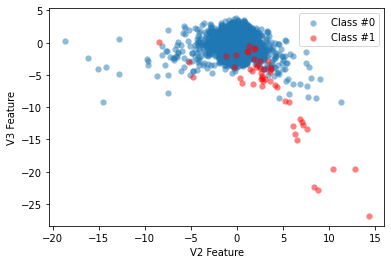

In [18]:
# Plot our data by running our plot data function on X and y (x = v2, y = v3, arbitrarily)
plot_data(X, y)

**By visualizing the data, you can immediately see how our fraud cases are scattered over our data, and how few cases we have. A picture often makes the imbalance problem clear. In the next exercises we'll visually explore how to improve our fraud to non-fraud balance.**

#### SMOTE

* ![smote](images/smote.jpeg)
* Synthetic minority Oversampling Technique (SMOTE)
    * [Resampling strategies for Imbalanced Data Sets](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)
    * Another way of adjusting the imbalance by oversampling minority observations
    * SMOTE uses characteristics of nearest neighbors of fraud cases to create new synthetic fraud cases
        * avoids duplicating observations

#### Determining the best resampling method is situational

* Random Undersampling (RUS):
    * If there is a lot of data and many minority cases, then undersampling may be computationally more convenient
        * In most cases, throwing away data is not desirable
* Random Oversampling (ROS):
    * Straightforward
    * Training the model on many duplicates
* SMOTE:
    * more sophisticated
    * realistic data set
    * training on synthetic data
    * only works well if the minority case features are similar
* VAEs/ GANs:
    * extremly more sophisticated
    * computationaly more intensive
    * more difficult to work with
    * needs large amounts of data
        * **if fraud is spread through the data and not distinct, using nearest neighbors to create more fraud cases, introduces noise into the data, as the nearest neighbors might not be fraud cases**

#### When to use resampling methods

* Use resampling methods on the training set, not on the test set
* The goal is to produce a better model by providing balanced data
    * The goal is not to predict the synthetic samples
* Test data should be free of duplicates and synthetic data
* Only test the model on real data
    * First, spit the data into train and test sets


### Applying Synthetic Minority Oversampling Technique (SMOTE)

Next, we re-balance our data using the **Synthetic Minority Over-sampling Technique** (SMOTE). Unlike ROS, SMOTE does not create exact copies of observations, but **creates new, synthetic, samples** that are quite similar to the existing observations in the minority class. SMOTE is therefore slightly more sophisticated than just copying observations, so we apply SMOTE to our credit card data. The dataset `df` is available and the packages needed for SMOTE are imported. In the following exercise, we visualize the result and compare it to the original data, such that we can see the effect of applying SMOTE very clearly.


In [19]:
# Run the prep_data function
X, y = prep_data(df)

In [20]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (5050, 28)
y shape: (5050,)


In [21]:
# Define the resampling method
method = SMOTE()

In [22]:
# Create the resampled feature set
X_resampled, y_resampled = method.fit_sample(X, y)

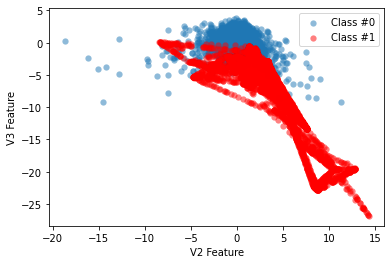

In [23]:
# Plot the resampled data
plot_data(X_resampled, y_resampled)

**The minority class is now much more prominently visible in our data. To see the results of SMOTE even better, we compare it to the original data.**

### Compare SMOTE to original data

In the last exercise, we saw that using SMOTE suddenly gives us more observations of the minority class. Let's compare those results to our original data, to get a good feeling for what has actually happened. Have a look at the value counts again of our old and new data, and plot the two scatter plots of the data side by side. Use the function compare_plot(), which takes the following arguments: `X`, `y`, `X_resampled`, `y_resampled`, `method=''`. The function plots the original data in a scatter plot, along with the resampled side by side.


In [24]:
pd.value_counts(pd.Series(y))

0    5000
1      50
dtype: int64

In [25]:
pd.value_counts(pd.Series(y_resampled))

1    5000
0    5000
dtype: int64

#### def compare_plot

In [26]:
def compare_plot(X: np.ndarray, y: np.ndarray, X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original Set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show()

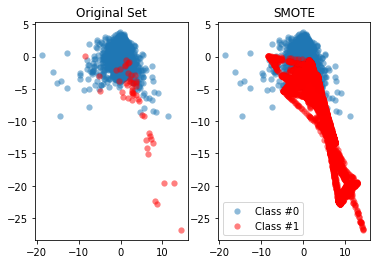

In [27]:
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

**It should be clear SMOTE has balanced the data completely, and that the minority class is now equal in size to the majority class. Visualizing the data shows the effect on the data very clearly. Next will demonstrate multiple ways to implement SMOTE and how each method will have a slightly different effect.**

#### SIDE NOTE: Advantages of ML Based Systems Rather than Rules Based Systems, Combinations are generally the best (Human Domain / Computer Pattern Recognition)

* Adapt to the data, thus can change over time
* Uses all the data combined, rather than a threshold per feature
* Produces a probability, rather than a binary score
* Typically have better performance and can be combined with rules

###  Logistic regression NOT using SMOTE

In [28]:
# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [29]:
# Fit a logistic regression model to our data
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [30]:
# Obtain model predictions
predicted = model.predict(X_test)

In [31]:
# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.89      0.80      0.84        10

    accuracy                           1.00      1515
   macro avg       0.94      0.90      0.92      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1504    1]
 [   2    8]]


### Logistic regression with SMOTE

Using the Logistic Regression model from the previous exercise, and combine that with a **SMOTE resampling method**. 


In [32]:
# Define which resampling method and which ML model to use in the pipeline
resampling = SMOTE()
model = LogisticRegression(solver='liblinear')

In [33]:
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

### Pipelining


In [34]:
# Split  data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [35]:
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

In [36]:
# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.67      1.00      0.80        10

    accuracy                           1.00      1515
   macro avg       0.83      1.00      0.90      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1500    5]
 [   0   10]]


**SMOTE slightly improves our results. We now manage to find all cases of fraud, but we have a slightly higher number of false positives, albeit only 5 cases. Remember, resampling doesn't necessarily lead to better results. When the fraud cases are very spread and scattered over the data, using SMOTE can introduce a bit of bias. Nearest neighbors aren't necessarily also fraud cases, so the synthetic samples might 'confuse' the model slightly.**

# FD2 Fraud Detection Using Labelled Data

In this exercise, you'll again use credit card transaction data. The features and labels are similar to the data in the previous example FD1

In [41]:
df2 = pd.read_csv(cc2_file)
df2.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,221547,-1.191668,0.428409,1.640028,-1.848859,-0.870903,-0.204849,-0.385675,0.352793,-1.098301,-0.334597,-0.679089,-0.039671,1.372661,-0.732001,-0.344528,1.024751,0.380209,-1.087349,0.364507,0.051924,0.507173,1.292565,-0.467752,1.244887,0.697707,0.059375,-0.319964,-0.017444,27.44,0
1,184524,1.966614,-0.450087,-1.228586,0.142873,-0.150627,-0.543590,-0.076217,-0.108390,0.973310,-0.029903,0.279973,0.885685,-0.583912,0.322019,-1.065335,-0.340285,-0.385399,0.216554,0.675646,-0.190851,0.124055,0.564916,-0.039331,-0.283904,0.186400,0.192932,-0.039155,-0.071314,35.95,0
2,91201,1.528452,-1.296191,-0.890677,-2.504028,0.803202,3.350793,-1.633016,0.815350,-1.884692,1.465259,-0.188235,-0.976779,0.560550,-0.250847,0.936115,0.136409,-0.078251,0.355086,0.127756,-0.163982,-0.412088,-1.017485,0.129566,0.948048,0.287826,-0.396592,0.042997,0.025853,28.40,0
3,26115,-0.774614,1.100916,0.679080,1.034016,0.168633,0.874582,0.209454,0.770550,-0.558106,-0.165442,0.017562,0.285377,-0.818739,0.637991,-0.370124,-0.605148,0.275686,0.246362,1.331927,0.080978,0.011158,0.146017,-0.130401,-0.848815,0.005698,-0.183295,0.282940,0.123856,43.20,0
4,201292,-1.075860,1.361160,1.496972,2.242604,1.314751,0.272787,1.005246,0.132932,-1.558317,0.484216,-1.967998,-1.818338,-2.036184,0.346962,-1.161316,1.017093,-0.926787,0.183965,-2.102868,-0.354008,0.254485,0.530692,-0.651119,0.626389,1.040212,0.249501,-0.146745,0.029714,10.59,0


In [42]:
X, y = prep_data(df2)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (7300, 28)
y shape: (7300,)


In [43]:
df2.Class.value_counts()

0    7000
1     300
Name: Class, dtype: int64

In [44]:
# Count the total number of observations from the length of y
total_obs = len(y)

# Count the total number of non-fraudulent observations 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

percentage = count_non_fraud/total_obs * 100
print(f'{percentage:0.2f}%')

95.89%


### Random Forest Classifier - part 1

Next, we create a **random forest classifier** for fraud detection. Hopefully we can perform better than the baseline accuracy you've just calculated, which was roughly **96%**. This model will serve as the **"baseline" model** that we are going to try to improve in the upcoming exercises. We start by **splitting the data into a test and training set**, and **defining the Random Forest model**

#### X_train, X_test, y_train, y_test

In [45]:
# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [47]:
# Define the model as the random forest, arbitrary 20 trees
model = RandomForestClassifier(random_state=5, n_estimators=20)

Next, we see how our Random Forest model performs **without hyperameter tuning**.

In [48]:
# Fit the model to our training set
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=5)

In [49]:
# Obtain predictions from the test data 
predicted = model.predict(X_test)

### Performance metrics for the RF model

We know **accuracy can be misleading** in the case of fraud detection. With highly imbalanced fraud data, the AUROC curve is a more reliable performance metric, used to compare different classifiers. Moreover, the *classification report* tells you about the precision and recall of your model, whilst the *confusion matrix* actually shows how many fraud cases you can predict correctly. So let's get these performance metrics.

In [50]:
# Obtain the predictions from our random forest model 
predicted = model.predict(X_test)

In [51]:
# Predict probabilities
probs = model.predict_proba(X_test)

In [52]:
# Print the ROC curve, classification report and confusion matrix
print('ROC Score:')
print(roc_auc_score(y_test, probs[:,1]))
print('\nClassification Report:')
print(classification_report(y_test, predicted))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, predicted))

ROC Score:
0.9419896444670147

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.98      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2097    2]
 [  18   73]]


**We obtained more meaningful performance metrics that tell us how well the model performs, given the highly imbalanced data that we are working with. The model predicts 75 cases of fraud, out of which 73 are actual fraud. We have only 2 false positives. This is acceptable, and as a result we have a very high precision score. However, we did miss 18 cases of actual fraud. Recall is therefore not as good as precision.**

### Additional: Plotting the Precision vs. Recall Curve

We Plot **Precision-Recall curve** to investigate the trade-off between the two in your model. In this curve **Precision and Recall are inversely related**; as Precision increases, Recall falls and vice-versa. A balance between these two needs to be achieved in your model, otherwise you might end up with many false positives, or not enough actual fraud cases caught. To achieve this and to compare performance, the precision-recall curves come in handy.

In [58]:
# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)
average_precision

0.7890250388880526

In [59]:
# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, predicted)
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))

Precision: [0.04155251 0.97333333 1.        ]
Recall: [1.        0.8021978 0.       ]


#### def plot_pr_curve

In [60]:
def plot_pr_curve(recall, precision, average_precision):
    """
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """
    from inspect import signature
    plt.figure()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title(f'2-class Precision-Recall curve: AP={average_precision:0.2f}')
    return plt.show()

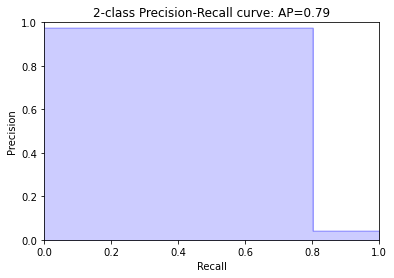

In [61]:
# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

**The ROC curve plots the true positives vs. false positives , for a classifier, as its discrimination threshold is varied. Since, a random method describes a horizontal curve through the unit interval, it has an AUC of 0.5. Minimally, classifiers should perform better than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is larger), they have better expected performance.**

### Parameter optimization with GridSearchCV for RF

Next use `GridSearchCV` to find optimal parameters for our RF.


#### def get_model_results

In [62]:
def get_model_results(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):
    """
    model: sklearn model (e.g. RandomForestClassifier)
    """
    # Fit your training model to your training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model 
    predicted = model.predict(X_test)
    
    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
        print(roc_auc_score(y_test, probs[:,1]))
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

In [63]:
# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30],
              'max_features': ['auto', 'log2'], 
              'max_depth': [4, 8, 10, 12],
              'criterion': ['gini', 'entropy']}

# Define the model to use
model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 30}

In [64]:
# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12},
                               criterion='gini',
                               max_depth=8,
                               max_features='log2', 
                               min_samples_leaf=10,
                               n_estimators=30,
                               n_jobs=-1,
                               random_state=5)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9749697658225529

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.95      0.84      0.89        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2095    4]
 [  15   76]]


**The model has been improved even further. The number of false negativs has now been slightly reduced even further 18 to 15, which means we are catching more cases of fraud, 73 to 76. However, you see that the number of false positives actually went up, 2 to 4. That is that Precision-Recall trade-off in action. To decide which final model is best, you need to take into account how bad it is not to catch fraudsters, versus how many false positives the fraud analytics team can deal with. Ultimately, this final decision should be made by you and the fraud team together.**

### Logistic Regression - A comparison to our RF

Implementing an Ensemble

The Voting Classifier can potentially improve your original mode by combining the strengths and weaknesses of many other models. 


In [65]:
# Define the Logistic Regression model with weights
model = LogisticRegression(class_weight={0:1, 1:15}, random_state=5, solver='liblinear')

# Get the model results
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9722054981702433

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2099
           1       0.63      0.88      0.73        91

    accuracy                           0.97      2190
   macro avg       0.81      0.93      0.86      2190
weighted avg       0.98      0.97      0.98      2190


Confusion Matrix:
[[2052   47]
 [  11   80]]


**As you can see the Logistic Regression has quite different performance from the Random Forest. More false positives, but also a better Recall. It will therefore will a useful addition to the Random Forest in an ensemble model.**

### Voting Classifier

Next we **combine three machine learning models into one**, to improve our Random Forest fraud detection model from before. We combine our usual Random Forest model, with the Logistic Regression from the previous exercise, with a simple Decision Tree. 

In [66]:
# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15},
                          random_state=5,
                          solver='liblinear')

clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, 
                              criterion='gini', 
                              max_depth=8, 
                              max_features='log2',
                              min_samples_leaf=10, 
                              n_estimators=30, 
                              n_jobs=-1,
                              random_state=5)

clf3 = DecisionTreeClassifier(random_state=5,
                              class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

# Get the results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2099
           1       0.90      0.86      0.88        91

    accuracy                           0.99      2190
   macro avg       0.95      0.93      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2090    9]
 [  13   78]]


**By combining the classifiers, you can take the best of multiple models. When compared to the RF model, we have increased the cases of fraud  from 76 to 78, and only have 5 extra false positives in return. If we care about catching as many fraud cases as we can, whilst keeping the false positives low, this is a pretty good trade-off. The Logistic Regression as a standalone was quite bad in terms of false positives, and the Random Forest was worse in terms of false negatives. By combining these together we managed to improve performance.**

### Adjusting weights within the Voting Classifier

The Voting Classifier allows improvement on fraud detection performance, by combining good aspects from multiple models. Next we **adjust the weights** we give to these models. By increasing or decreasing weights illustrate **how much emphasis to give to a particular model** relative to the rest. This is useful when a certain model has overall better performance than the rest, but still want to combine aspects of the others to further improve your results.

In [67]:
# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

# Get results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

ROC Score:
0.9739226947421326

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.94      0.85      0.89        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2094    5]
 [  14   77]]


**The weight option allows individual models to get the optimal wighting mix for the fraud detection model. Weights must be experimented with to determine optimal allocation**

# FD3 Fraud Detection Using Unlabeled Data

Unsupervised learning techniques to detect fraud. Segment customers, use K-means clustering and other clustering algorithms to find suspicious occurrences.

### Exploring the data

Next we look at bank **payment transaction data**. The financial transactions are categorized by type of expense, as well as the amount spent. Moreover, some client characteristics are available such as age group and gender.

When using unsupervised learning techniques for fraud detection, **distinguish normal from abnormal** (thus potentially fraudulent) behavior. A fraud analyst would best understand what is "normal".

In [68]:
banksim_df = pd.read_csv(banksim_file)
banksim_df.drop(['Unnamed: 0'], axis=1, inplace=True)
banksim_adj_df = pd.read_csv(banksim_adj_file)
banksim_adj_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [69]:
banksim_df.shape

(7200, 5)

In [70]:
banksim_df.head()

,age,gender,category,amount,fraud
0,3,F,es_transportation,49.71,0
1,4,F,es_health,39.29,0
2,3,F,es_transportation,18.76,0
3,4,M,es_transportation,13.95,0
4,2,M,es_transportation,49.87,0


In [71]:
banksim_adj_df.shape

(7189, 18)

In [72]:
banksim_adj_df.head()

,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [73]:
banksim_df.groupby(['category']).mean()

,amount,fraud
category,,
es_barsandrestaurants,43.841793,0.022472
es_contents,55.170000,0.000000
es_fashion,59.780769,0.020619
es_food,35.216050,0.000000
es_health,126.604704,0.242798
es_home,120.688317,0.208333
es_hotelservices,172.756245,0.548387
es_hyper,46.788180,0.125000
es_leisure,229.757600,1.000000


### Customer segmentation

Chekcing for any **obvious patterns** for the clients in this data, we need to determine if there a need to segment your data into groups, aka homogenous populations.

Unfortunately there is not a lot client information available; for example we can not distinguish between the wealth levels of different clients. However, there is data on **age ** available.


In [74]:
banksim_df.groupby(['age']).mean()

,amount,fraud
age,,
0,49.468935,0.050000
1,35.622829,0.026648
2,37.228665,0.028718
3,37.279338,0.023283
4,36.197985,0.035966
5,37.547521,0.023990
6,36.700852,0.022293
U,39.117000,0.000000


In [75]:
banksim_df.age.value_counts()

2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64

**The average amount spent as well as fraud occurrence is rather similar across groups. Age group '0' stands out but since there are only 40 cases, it does not make sense to split these out in a separate group and run a separate model on them.**

### Using statistics to define normal behavior

There is no obvious way to segment our data into for example age groups. However, we can investigate the **average amounts spent** in normal transactions versus fraud transactions. Giving an idea of how fraudulent transactions **differ structurally** from normal transactions.

In [76]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = banksim_df[banksim_df.fraud == 1] 
df_non_fraud = banksim_df[banksim_df.fraud == 0]

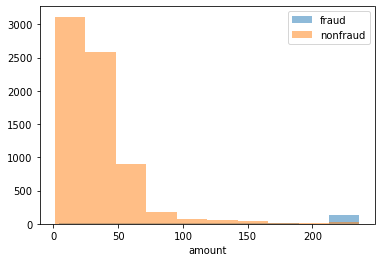

In [77]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.xlabel('amount')
plt.legend()
plt.show()

**As the number fraud observations is much smaller, it is difficult to see the full distribution. Nonetheless, you can see that the fraudulent transactions tend to be on the larger side relative to normal observations. This is good news, as it helps us later in detecting fraud from non-fraud. In the next chapter you're going to implement a clustering model to distinguish between normal and abnormal transactions, when the fraud labels are no longer available.**

## Clustering methods to detect fraud

A very commonly used clustering algorithm is K-means clustering. For fraud detection, K-means clustering is straightforward to implement and relatively powerful in predicting suspicious cases. It is a good algorithm to start with when working on fraud detection problems. However, fraud data is oftentimes very large, especially when working with transaction data. MiniBatch K-means is an efficient way to implement K-means on a large datasets.

In [78]:
labels = banksim_adj_df.fraud

In [79]:
cols = ['age', 'amount', 'M', 'es_barsandrestaurants', 'es_contents',
        'es_fashion', 'es_food', 'es_health', 'es_home', 'es_hotelservices',
        'es_hyper', 'es_leisure', 'es_otherservices', 'es_sportsandtoys',
        'es_tech', 'es_transportation', 'es_travel']

In [80]:
# Take the float values of df for X
X = banksim_adj_df[cols].values.astype(np.float)

In [81]:
X.shape

(7189, 17)

In [82]:
# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [68]:
# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

MiniBatchKMeans(random_state=0)

**Having fit the MiniBatch K-means model to the data, we still need to figure our what the right number of clusters to use is. Let's do that in the next exercise.**

### Elbow Method to Determine K

- Elbow Method
- Silhouette Analysis
- Davies-Bouldin Index

In [83]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

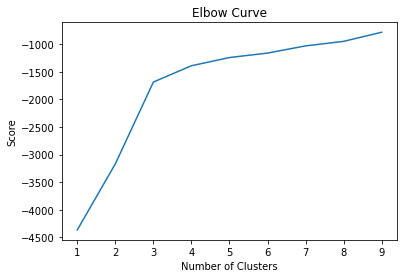

In [84]:
# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

**The optimal number of clusters should probably be at around 3 clusters, as that is where the elbow is in the curve. We'll use this in the next exercise as our baseline model, and see how well this does in detecting fraud**

#### Validating the K-Minibatch Model Results

* without fraud labels, the usual performance metrics can't be run
    * check with the fraud analyst
    * investigate and describe cases that are flagged in more detail
        * is it fraudulent or just a rare case of legit data
        * avoid rare, legit cases by deleting certain features or removing the cases from the data
    * if there are past cases of fraud, see if the model can predict them using historic data

### Detecting outliers

Using the K-means algorithm to predict fraud, and we compare those predictions to the actual labels that are saved, to sense check our results (since we don't have an actual fraud analyst)


In [85]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

In [86]:
def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-
        examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [87]:
# Obtain the ROC score
roc_auc_score(y_test, km_y_pred)

0.8109115999408585

Confusion matrix, without normalization


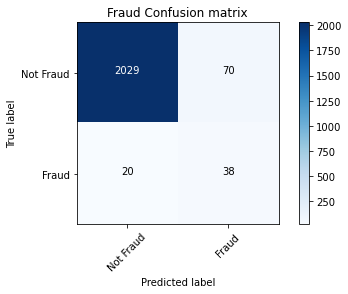

In [88]:
# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

## Alternate clustering methods for fraud detection

* In addition to K-means, there are many different clustering methods, which can be used for fraud detection
* ![clustering methods](images/clustering_methods.jpeg)
* K-means works well when the data is clustered in normal, round shapes
* There are methods to flag fraud other the cluster outliers
* ![clustering outlier](images/cluster_outlier.jpeg)
    * **Small clusters can be an indication of fraud**
    * This approach can be used when fraudulent behavior has commonalities, which cause clustering
    * The fraudulent data would cluster in tiny groups, rather than be the outliers of larger clusters
* ![typical data](images/typical_data.jpeg)
    * In this case there are 3 obvious clusters
    * The smallest dots are outliers and outside of what can be described as normal behavior
    * There are also small to medium clusters closely connected to the red cluster
    * Visualizing the data with something like [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) can be quite helpful

#### DBSCAN: Density-Based Spatial Clustering of Applications with Noise

* [DBscan](https://en.wikipedia.org/wiki/DBSCAN)
* DBSCAN vs. K-means
    * The number of clusters does not need to be predefined
        * The algorithm finds core samples of high density and expands clusters from them
        * **Works well on data containing clusters of similar density**
    * This type of algorithm can be used to identify fraud as very small clusters
    * Assignments: Maximum allowed distance between points in a cluster must be assigned
    * Assignments: Minimal number of data points in clusters must be assigned
    * Better performance on weirdly shaped data
    * Computationally heavier then MiniBatch K-means

### DB Scan

In [89]:
# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

In [90]:
# Print performance metrics for DBscan
print(f'Estimated number of clusters: {n_clusters}')
print(f'Homogeneity: {homogeneity_score(labels, pred_labels):0.3f}')
print(f'Silhouette Coefficient: {silhouette_score(X_scaled, pred_labels):0.3f}')

Estimated number of clusters: 23
Homogeneity: 0.612
Silhouette Coefficient: 0.713


**The number of clusters is much higher than with K-means. For fraud detection this is for now OK, as we are only interested in the smallest clusters, since those are considered as abnormal. Now have a look at those clusters and decide which one to flag as fraud.**

### Assessing smallest clusters - DB Scan

In [91]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)

[3252  145 2714   55  174  119  122   98   54   15   76   15   43   25
   51   47   42   15   25   20   19   10]


In [92]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

In [93]:
# Print the results 
print(f'The smallest clusters are clusters: {smallest_clusters}')

The smallest clusters are clusters: [21 17  9]


In [94]:
# Print the counts of the smallest clusters only
print(f'Their counts are: {counts[smallest_clusters]}')

Their counts are: [10 15 15]


**So now we know which smallest clusters you could flag as fraud. If you were to take more of the smallest clusters, you cast your net wider and catch more fraud, but most likely also more false positives. It is up to the fraud analyst to find the right amount of cases to flag and to investigate. In the next exercise you'll check the results with the actual labels.**

### Results verification


In [95]:
# Create a dataframe of the predicted cluster numbers and fraud labels 
df = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Create a condition flagging fraud for the smallest clusters 
df['predicted_fraud'] = np.where((df['clusternr'].isin([21, 17, 9])), 1 , 0)

In [96]:
# Run a crosstab on the results 
print(pd.crosstab(df['fraud'], df['predicted_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud     0   1
Actual Fraud           
0              6973  16
1               176  24


**Compared to the K-means model, we have significantly less false positives, 70 to 16, however we have significantly more false negatives 20 to 176 and catch overall less fraud, 38 to 24. The good thing is: our of all flagged cases, roughly 16/24 are actually fraud with is higher than 38/70. Since you only take the three smallest clusters, by definition you flag less cases of fraud, so you catch less but also have less false positives. However, you are missing quite a lot of fraud cases. Increasing the amount of smallest clusters you flag could improve that, but at the cost of more false positives.**

# FD4 Fraud Detection using NLP

Text data, text mining and topic modeling to detect fraudulent behavior.

### Word search with dataframes

Lastly, we will use text data, containing emails from Enron employees. The **Enron scandal** is a famous fraud case. Enron employees covered up the bad financial position of the company, thereby keeping the stock price artificially high. Enron employees sold their own stock options, and when the truth came out, Enron investors were left with nothing. The goal is to find all emails that mention specific words, such as "sell enron stock".

### Simple Term Search - Rules

In [103]:
df = pd.read_csv(enron_emails_clean_file)

In [104]:
mask = df['clean_content'].str.contains('sell enron stock', na=False)

In [105]:
# Select the data from df using the mask
df[mask]

,Message-ID,From,To,Date,content,clean_content
154,<6336501.1075841154311.JavaMail.evans@thyme>,('sarah.palmer@enron.com'),('sarah.palmer@enron.com'),2002-02-01 14:53:35,\nJoint Venture: A 1997 Enron Meeting Belies O...,joint venture enron meeting belies officers cl...


**You see that searching for particular string values in a dataframe can be relatively easy, and allows you to include textual data into your model or analysis. You can use this word search as an additional flag, or as a feature in your fraud detection model. Let's look at how to filter the data using multiple search terms.**

### Using List of Search Terms

Oftentimes we don't want to search on just one term. You probably can create a full **"fraud dictionary"** of terms that could potentially **flag fraudulent clients** and/or transactions. Fraud analysts often will have an idea what should be in such a dictionary. In this exercise you're going to **flag a multitude of terms**. We can use this in machine learning models as a feature, or as an additional filter on top of your machine learning model results.

In [106]:
# Create a list of terms to search for
searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']

# Filter cleaned emails on searchfor list and select from df 
filtered_emails = df[df.clean_content.str.contains('|'.join(searchfor), na=False)]
filtered_emails.head()

,Message-ID,From,To,Date,content,clean_content
0,<8345058.1075840404046.JavaMail.evans@thyme>,('advdfeedback@investools.com'),('advdfeedback@investools.com'),2002-01-29 23:20:55,INVESTools Advisory\nA Free Digest of Trusted ...,investools advisory free digest trusted invest...
1,<1512159.1075863666797.JavaMail.evans@thyme>,('richard.sanders@enron.com'),('richard.sanders@enron.com'),2000-09-20 19:07:00,----- Forwarded by Richard B Sanders/HOU/ECT o...,forwarded richard b sanders hou ect pm justin ...
2,<26118676.1075862176383.JavaMail.evans@thyme>,('m..love@enron.com'),('m..love@enron.com'),2001-10-30 16:15:17,hey you are not wearing your target purple shi...,hey wearing target purple shirt today mine wan...
3,<10369289.1075860831062.JavaMail.evans@thyme>,('leslie.milosevich@kp.org'),('leslie.milosevich@kp.org'),2002-01-30 17:54:18,Leslie Milosevich\n1042 Santa Clara Avenue\nAl...,leslie milosevich santa clara avenue alameda c...
4,<26728895.1075860815046.JavaMail.evans@thyme>,('rtwait@graphicaljazz.com'),('rtwait@graphicaljazz.com'),2002-01-30 19:36:01,"Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501...",rini twait e th ave longmont co rtwait graphic...


**By joining the search terms we can search on a multitude of terms in the dataset with minimal effort.**

### Creating a flag on search terms

In [107]:
# Create flag variable where the emails match the searchfor terms
df['flag'] = np.where((df['clean_content'].str.contains('|'.join(searchfor)) == True), 1, 0)

# Count the values of the flag variable
count = df['flag'].value_counts()
print(count)

0    1776
1     314
Name: flag, dtype: int64


## Text Mining to Detect Fraud

### Text Preprocessing


In [108]:
# import nltk
# nltk.download()

In [109]:
# Define stopwords to exclude
stop = set(stopwords.words('english'))
stop.update(("to", "cc", "subject", "http", "from", "sent", "ect", "u", "fwd", "www", "com", 'html'))

# Define punctuations to exclude and lemmatizer
exclude = set(string.punctuation)

### Cleaning text data

Now that you've defined the **stopwords and punctuations**, let's use these to clean our enron emails in the dataframe `df` further. The lists containing stopwords and punctuations are available under `stop` and `exclude` There are a few more steps to take before you have cleaned data, such as **"lemmatization"** of words, and **stemming the verbs**. The verbs in the email data are already stemmed, and the lemmatization is already done.

In [110]:
# Import the lemmatizer from nltk
lemma = WordNetLemmatizer()

def clean(text, stop):
    text = str(text).rstrip()
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(i for i in stop_free if i not in exclude)
    normalized = " ".join(lemma.lemmatize(i) for i in punc_free.split())      
    return normalized

In [111]:
# Clean the emails in df and print results
text_clean=[]
for text in df['clean_content']:
    text_clean.append(clean(text, stop).split())    

In [112]:
text_clean[0][:10]

['investools',
 'advisory',
 'free',
 'digest',
 'trusted',
 'investment',
 'advice',
 'unsubscribe',
 'free',
 'newsletter']

**After text preprocessing, including splitting the text into words, removing stopwords and punctuations, and lemmatizing your words, we then run a topic model on this data.

## Topic modeling on fraud

1. Discovering topics in text data
1. "What is the text about"
1. Conceptually similar to clustering data
1. Compare topics of fraud cases to non-fraud cases and use as a feature or flag
1. Or.. is there a particular topic in the data that seems to point to fraud?

### Create dictionary and corpus

In order to run an LDA topic model, you first need to **define your dictionary and corpus** first, as those need to go into the model. You're going to continue working on the cleaned text data that you've done in the previous exercises. That means that `text_clean` is available for you already to continue working with, and you'll use that to create your dictionary and corpus.

This exercise will take a little longer to execute than usual.

**Instructions**

* Import the gensim package and corpora from gensim separately.
* Define your dictionary by running the correct function on your clean data `text_clean`.
* Define the corpus by running `doc2bow` on each piece of text in `text_clean`.
* Print your results so you can see `dictionary` and `corpus` look like.

In [113]:
# Define the dictionary
dictionary = corpora.Dictionary(text_clean)

# Define the corpus 
corpus = [dictionary.doc2bow(text) for text in text_clean]

In [114]:
print(dictionary)

Dictionary(33980 unique tokens: ['account', 'accurate', 'acquiring', 'acre', 'address']...)


In [115]:
corpus[0][:10]

[(0, 2),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 6),
 (6, 1),
 (7, 2),
 (8, 4),
 (9, 1)]

**These are the two ingredients you need to run your topic model on the enron emails. You are now ready for the final step and create your first fraud detection topic model.**

### LDA model

Now it's time to **build the LDA model**. Using the `dictionary` and `corpus`, you are ready to discover which topics are present in the Enron emails. With a quick print of words assigned to the topics, you can do a first exploration about whether there are any obvious topics that jump out. Be mindful that the topic model is **heavy to calculate** so it will take a while to run. Let's give it a try!

**Instructions**

* Build the LDA model from gensim models, by inserting the `corpus` and `dictionary`.
* Save the 5 topics by running `print_topics` on the model results, and select the top 5 words.

In [116]:
# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=5)

# Save the topics and top 5 words
topics = ldamodel.print_topics(num_words=5)

# Print the results
for topic in topics:
    print(topic)

(0, '0.050*"image" + 0.014*"se" + 0.014*"ne" + 0.013*"sp" + 0.013*"wscc"')
(1, '0.008*"enron" + 0.008*"e" + 0.007*"mail" + 0.007*"email" + 0.006*"schedule"')
(2, '0.038*"enron" + 0.009*"company" + 0.007*"hou" + 0.005*"development" + 0.005*"energy"')
(3, '0.043*"td" + 0.031*"net" + 0.029*"money" + 0.028*"tr" + 0.025*"width"')
(4, '0.017*"enron" + 0.012*"message" + 0.012*"pm" + 0.011*"original" + 0.006*"thanks"')


**We created a topic model on the Enron email data. However, the print of words doesn't really give enough information to find a topic that might show signs of fraud. Therefore we need to closely inspect the model results in order to be able to detect anything that can be related to fraud in the data.**

## Flagging fraud based on topic

#### Explanability - To understand topics, you need to visualize and peer into the black box (interpretability)


In [117]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)

In [118]:
pyLDAvis.display(lda_display)

### Interpreting the topic model

* Words like 'stock', 'know', 'would'may imply insider trading of Enron Stock amongst it's employees. 
* Slide the lambda value to .2. Words like 'bankruptcy", "retirement", "fund" appear in Topic 3
* Resources: http://bl.ocks.org/AlessandraSozzi/raw/ce1ace56e4aed6f2d614ae2243aab5a5/

### Finding fraudsters based on topic

Next we **link the results** from the topic model **back to the original data**. We want to **flag everything related to topic 3**. As you will see, this is actually not that straightforward.

More detail on how to work with the model results (which is beyond the scope of this notebook) please look here [article](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/).


#### def get_topic_details

In [99]:
def get_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_details_df = topic_details_df.append(pd.Series([topic_num, prop_topic]), ignore_index=True)
    topic_details_df.columns = ['Dominant_Topic', '% Score']
    return topic_details_df

In [100]:
# Run get_topic_details function and check the results
topic_details_df = get_topic_details(ldamodel, corpus)

In [101]:
topic_details_df.head()

,Dominant_Topic,% Score
0,3.0,0.939578
1,4.0,0.703105
2,4.0,0.343857
3,3.0,0.993440
4,3.0,0.993387


In [102]:
topic_details_df.tail()

,Dominant_Topic,% Score
2085,0.0,0.909964
2086,1.0,0.599331
2087,0.0,0.999323
2088,4.0,0.998147
2089,4.0,0.988427


In [103]:
# Add original text to topic details in a dataframe
contents = pd.DataFrame({'Original text': text_clean})
topic_details = pd.concat([get_topic_details(ldamodel, corpus), contents], axis=1)

In [104]:
topic_details.sort_values(by=['% Score'], ascending=False).head(10).head()

,Dominant_Topic,% Score,Original text
849,0.0,0.999874,"[original, message, received, thu, aug, cdt, e..."
2081,2.0,0.999631,"[unsubscribe, mailing, please, go, money, net,..."
2087,0.0,0.999323,"[image, image, image, image, image, image, ima..."
2088,4.0,0.998147,"[transmission, expansion, system, transition, ..."
2014,0.0,0.997874,"[forwarded, chris, h, foster, hou, pm, enron, ..."


In [105]:
topic_details.sort_values(by=['% Score'], ascending=False).head(10).tail()

,Dominant_Topic,% Score,Original text
769,1.0,0.997854,"[congratulation, mark, haedicke, michael, guer..."
1044,1.0,0.997853,"[forwarded, steven, j, kean, na, enron, pm, ka..."
1084,1.0,0.997853,"[forwarded, steven, j, kean, na, enron, pm, ka..."
2076,1.0,0.997741,"[know, houston, suck, xo, j, original, message..."
2039,1.0,0.997667,"[w, e, e, k, e, n, e, v, l, b, l, f, r, decemb..."


In [106]:
# Create flag for text highest associated with topic 3
topic_details['flag'] = np.where((topic_details['Dominant_Topic'] == 4.0), 1, 0)

In [107]:
topic_details_1 = topic_details[topic_details.flag == 1]

In [108]:
topic_details_1.sort_values(by=['% Score'], ascending=False).head(10)

,Dominant_Topic,% Score,Original text,flag
2088,4.0,0.998147,"[transmission, expansion, system, transition, ...",1
624,4.0,0.995344,"[vance, deal, created, entered, sitara, noted,...",1
2060,4.0,0.995330,"[preparation, continuing, simulation, thursday...",1
2080,4.0,0.994272,"[confident, work, thanks, gp, original, messag...",1
2074,4.0,0.993150,"[dear, friend, hot, deal, value, one, opt, sub...",1
990,4.0,0.992786,"[fyi, forwarded, stinson, gibner, hou, pm, nic...",1
2035,4.0,0.992513,"[hello, greg, belated, congrats, new, post, en...",1
616,4.0,0.992278,"[fyi, original, message, majorwitz, buddy, tue...",1
2032,4.0,0.992193,"[forwarded, mark, breese, hou, enron, capital,...",1
2033,4.0,0.992086,"[dear, valued, customer, got, great, news, new...",1


**You have now flagged all data that is highest associated with topic 2 that seems to cover internal conversation about enron stock options. **

## Recap

### FD1: Working with imbalanced data

* Worked with highly imbalanced fraud data
* Resample your data
* Different resampling methods

### FD2: Fraud detection with labeled data

* Refreshed supervised learning techniques to detect fraud
* Learned how to get reliable performance metrics and worked with the precision recall trade-off
* Explored how to optimize your model parameters to handle fraud data
* Applied ensemble methods to fraud detection

### FD3: Fraud detection without labels

* Learned about the importance of segmentation
* Refreshed your knowledge on clustering methods
* Learned how to detect fraud using outliers and small clusters with K-means clustering
* Applied a DB-scan clustering model for fraud detection

### FD4: Text mining for fraud detection

* Know how to augment fraud detection analysis with text mining techniques
* Applied word searches to flag use of certain words, and learned how to apply topic modeling for fraud detection
* Learned how to effectively clean messy text data

### Further Exploration for fraud detection

* Network analysis to detect fraud
* Different supervised and unsupervised learning techniques (e.g. Neural Networks)
* Working with very large data